In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [5]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [50] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [6]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [189]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]+1
            dim1 = r
        else:
            dim0=arch[i-1]+1
            dim1= arch[i]
        theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        #theta[i] = np.vstack((np.zeros((1,dim1)),theta[i]))
        #theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [190]:
theta = theta_init([50,50])
print(len(theta))
for i in range(len(theta)):
    print(theta[i].shape)
#print(theta[1])
# fm = forward_prop(X_train, theta)
# #print(fm.shape)
# print(fm[1].shape)
# print(theta[2].shape)
#np.hstack((fm,np.ones((fm.shape[0],1))))

3
(785, 50)
(51, 50)
(51, 26)


In [176]:
def activation(x):
    return 1/(1+np.exp(-x))

In [177]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
        if (l!=len(theta)-1):
            fm[l+1]=np.hstack((np.ones((fm[l+1].shape[0],1)),fm[l+1]))
    return fm

In [178]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [179]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [180]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

plt_epoch = []
plt_train_acc = []
plt_val_acc = []
plt_test_acc = []
costs= []

In [186]:
arch_test = [100]

In [191]:
lr = 0.5
for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]])
    print(theta[0].shape, theta[1].shape)
    early_stop=0
    epoch = 1
    start = time.time()
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])

    while(True):
        count = 0
        
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                    #print("delta for last layer = ", delta[l].shape)
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
                    #print(theta[l])
                    #print("delta for hidden layer = ", delta[l])


            for t in range(len(theta)):
                if (t == len(theta)-1):
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 
                else:
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1])[:,1:]
                    
            count+=1
            
#         if epoch %10 == 0:
#                 costs.append(cost_init)
#         if (epoch % 200 == 0):
#             plt_epoch.append(epoch)
#             plt_train_acc.append(calc_accuracy(X_train, theta, train_class_enc))
#             plt_val_acc.append(calc_accuracy(X_valid, theta, valid_class_enc))
#             plt_test_acc.append(calc_accuracy(X_test, theta, test_actual_class_enc))
        
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        if (abs(cost_final-cost_init) < 1e-05):
            early_stop +=1
        else:
            early_stop=0
        if (early_stop == 10):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break
        cost_init = cost_final
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {:2.3f}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

(785, 100) (101, 26)
Initial Cost on Val dataset for this epoch 1 = 3.203075572620993
Error on this batch = 3.20192575478171
Error on this batch = 0.48132695811154014
Cost on val dataset after 2 epochs is = 0.48107368159113284
Initial Cost on Val dataset for this epoch 2 = 0.48107368159113284
Error on this batch = 0.48109173425050367
Error on this batch = 0.4812360322985065
Cost on val dataset after 3 epochs is = 0.4810058772345283
Initial Cost on Val dataset for this epoch 3 = 0.4810058772345283
Error on this batch = 0.4810090250088983
Error on this batch = 0.4811619973533695
Cost on val dataset after 4 epochs is = 0.48092591063189416
Initial Cost on Val dataset for this epoch 4 = 0.48092591063189416
Error on this batch = 0.48092532257157444
Error on this batch = 0.4810723888402336
Cost on val dataset after 5 epochs is = 0.4808361010773896
Initial Cost on Val dataset for this epoch 5 = 0.4808361010773896
Error on this batch = 0.4808315318011796
Error on this batch = 0.4809699349218046

Cost on val dataset after 41 epochs is = 0.2066027450675806
Initial Cost on Val dataset for this epoch 41 = 0.2066027450675806
Error on this batch = 0.19071806121393947
Error on this batch = 0.17163546788659723
Cost on val dataset after 42 epochs is = 0.20109672258987907
Initial Cost on Val dataset for this epoch 42 = 0.20109672258987907
Error on this batch = 0.18407573463813554
Error on this batch = 0.16505787648328885
Cost on val dataset after 43 epochs is = 0.19609214018298673
Initial Cost on Val dataset for this epoch 43 = 0.19609214018298673
Error on this batch = 0.17790298611929614
Error on this batch = 0.15888466065975768
Cost on val dataset after 44 epochs is = 0.1915390344275393
Initial Cost on Val dataset for this epoch 44 = 0.1915390344275393
Error on this batch = 0.17219546626385906
Error on this batch = 0.15309198172585767
Cost on val dataset after 45 epochs is = 0.18738979491361907
Initial Cost on Val dataset for this epoch 45 = 0.18738979491361907
Error on this batch = 0

Cost on val dataset after 80 epochs is = 0.1315252284299126
Initial Cost on Val dataset for this epoch 80 = 0.1315252284299126
Error on this batch = 0.09522633065123383
Error on this batch = 0.07171931507137305
Cost on val dataset after 81 epochs is = 0.13081108890112736
Initial Cost on Val dataset for this epoch 81 = 0.13081108890112736
Error on this batch = 0.0943645218227529
Error on this batch = 0.07079004799522051
Cost on val dataset after 82 epochs is = 0.13011574142982257
Initial Cost on Val dataset for this epoch 82 = 0.13011574142982257
Error on this batch = 0.09352686124110732
Error on this batch = 0.06988520899738704
Cost on val dataset after 83 epochs is = 0.12943831383360815
Initial Cost on Val dataset for this epoch 83 = 0.12943831383360815
Error on this batch = 0.09271202170634911
Error on this batch = 0.06900363244859771
Cost on val dataset after 84 epochs is = 0.1287779891224119
Initial Cost on Val dataset for this epoch 84 = 0.1287779891224119
Error on this batch = 0.

Cost on val dataset after 119 epochs is = 0.11260452411384692
Initial Cost on Val dataset for this epoch 119 = 0.11260452411384692
Error on this batch = 0.07277413334395462
Error on this batch = 0.046687209531869237
Cost on val dataset after 120 epochs is = 0.11227314662764142
Initial Cost on Val dataset for this epoch 120 = 0.11227314662764142
Error on this batch = 0.07237609884324456
Error on this batch = 0.04625183570475926
Cost on val dataset after 121 epochs is = 0.11194659776264478
Initial Cost on Val dataset for this epoch 121 = 0.11194659776264478
Error on this batch = 0.07198257672195317
Error on this batch = 0.04582658652938146
Cost on val dataset after 122 epochs is = 0.11162474819426985
Initial Cost on Val dataset for this epoch 122 = 0.11162474819426985
Error on this batch = 0.07159342019622977
Error on this batch = 0.04541144033353919
Cost on val dataset after 123 epochs is = 0.11130747396318573
Initial Cost on Val dataset for this epoch 123 = 0.11130747396318573
Error on

Error on this batch = 0.035421335008488354
Cost on val dataset after 158 epochs is = 0.10237939063350147
Initial Cost on Val dataset for this epoch 158 = 0.10237939063350147
Error on this batch = 0.059918104906193204
Error on this batch = 0.035217579446122395
Cost on val dataset after 159 epochs is = 0.10217177210874005
Initial Cost on Val dataset for this epoch 159 = 0.10217177210874005
Error on this batch = 0.05964956675777797
Error on this batch = 0.035016612188106686
Cost on val dataset after 160 epochs is = 0.10196623126418207
Initial Cost on Val dataset for this epoch 160 = 0.10196623126418207
Error on this batch = 0.059383598874218006
Error on this batch = 0.03481834431312313
Cost on val dataset after 161 epochs is = 0.1017627375367762
Initial Cost on Val dataset for this epoch 161 = 0.1017627375367762
Error on this batch = 0.0591201622220619
Error on this batch = 0.03462268989051628
Cost on val dataset after 162 epochs is = 0.10156126095576282
Initial Cost on Val dataset for th

Error on this batch = 0.02892621231705781
Cost on val dataset after 197 epochs is = 0.09557701281226759
Initial Cost on Val dataset for this epoch 197 = 0.09557701281226759
Error on this batch = 0.05098295423364138
Error on this batch = 0.02878621068674571
Cost on val dataset after 198 epochs is = 0.09543167379908966
Initial Cost on Val dataset for this epoch 198 = 0.09543167379908966
Error on this batch = 0.05078574378694677
Error on this batch = 0.028647093358504218
Cost on val dataset after 199 epochs is = 0.09528754818246855
Initial Cost on Val dataset for this epoch 199 = 0.09528754818246855
Error on this batch = 0.05058973643204325
Error on this batch = 0.028508842038049275
Cost on val dataset after 200 epochs is = 0.0951446231269291
Initial Cost on Val dataset for this epoch 200 = 0.0951446231269291
Error on this batch = 0.05039491546520058
Error on this batch = 0.02837143959723738
Cost on val dataset after 201 epochs is = 0.09500288609900893
Initial Cost on Val dataset for this

Error on this batch = 0.02403967161898596
Cost on val dataset after 236 epochs is = 0.09070515410514904
Initial Cost on Val dataset for this epoch 236 = 0.09070515410514904
Error on this batch = 0.044101864192155664
Error on this batch = 0.02392944177052576
Cost on val dataset after 237 epochs is = 0.09059916530171394
Initial Cost on Val dataset for this epoch 237 = 0.09059916530171394
Error on this batch = 0.043946876518224126
Error on this batch = 0.023820004557720004
Cost on val dataset after 238 epochs is = 0.09049401442877603
Initial Cost on Val dataset for this epoch 238 = 0.09049401442877603
Error on this batch = 0.04379303170885871
Error on this batch = 0.023711364815677958
Cost on val dataset after 239 epochs is = 0.09038969570293598
Initial Cost on Val dataset for this epoch 239 = 0.09038969570293598
Error on this batch = 0.04364033924041609
Error on this batch = 0.023603527399101827
Cost on val dataset after 240 epochs is = 0.09028620343092922
Initial Cost on Val dataset for

Cost on val dataset after 274 epochs is = 0.08722304416093421
Initial Cost on Val dataset for this epoch 274 = 0.08722304416093421
Error on this batch = 0.03906374099536623
Error on this batch = 0.02035029404912381
Cost on val dataset after 275 epochs is = 0.08714546490104953
Initial Cost on Val dataset for this epoch 275 = 0.08714546490104953
Error on this batch = 0.03895469306937863
Error on this batch = 0.020271407327376815
Cost on val dataset after 276 epochs is = 0.08706855372037767
Initial Cost on Val dataset for this epoch 276 = 0.08706855372037767
Error on this batch = 0.03884674800153386
Error on this batch = 0.020193166384228082
Cost on val dataset after 277 epochs is = 0.08699230530764483
Initial Cost on Val dataset for this epoch 277 = 0.08699230530764483
Error on this batch = 0.03873988989857195
Error on this batch = 0.02011555299901248
Cost on val dataset after 278 epochs is = 0.08691671400540904
Initial Cost on Val dataset for this epoch 278 = 0.08691671400540904
Error o

Cost on val dataset after 313 epochs is = 0.0846380164887149
Initial Cost on Val dataset for this epoch 313 = 0.0846380164887149
Error on this batch = 0.035467173483232126
Error on this batch = 0.017618733307272313
Cost on val dataset after 314 epochs is = 0.08458253044766632
Initial Cost on Val dataset for this epoch 314 = 0.08458253044766632
Error on this batch = 0.03538869564192583
Error on this batch = 0.01755666858539995
Cost on val dataset after 315 epochs is = 0.08452755531745987
Initial Cost on Val dataset for this epoch 315 = 0.08452755531745987
Error on this batch = 0.035310755760556346
Error on this batch = 0.017495049202945142
Cost on val dataset after 316 epochs is = 0.08447308879156398
Initial Cost on Val dataset for this epoch 316 = 0.08447308879156398
Error on this batch = 0.03523334709866915
Error on this batch = 0.017433880345110637
Cost on val dataset after 317 epochs is = 0.08441912823670326
Initial Cost on Val dataset for this epoch 317 = 0.08441912823670326
Error 

Error on this batch = 0.015577025901046938
Cost on val dataset after 352 epochs is = 0.08280383191465561
Initial Cost on Val dataset for this epoch 352 = 0.08280383191465561
Error on this batch = 0.032762283954533386
Error on this batch = 0.01553120004023588
Cost on val dataset after 353 epochs is = 0.0827636876771957
Initial Cost on Val dataset for this epoch 353 = 0.0827636876771957
Error on this batch = 0.03270160218105844
Error on this batch = 0.015485708276993604
Cost on val dataset after 354 epochs is = 0.08272376620100692
Initial Cost on Val dataset for this epoch 354 = 0.08272376620100692
Error on this batch = 0.03264128928813168
Error on this batch = 0.015440547882220332
Cost on val dataset after 355 epochs is = 0.0826840591443847
Initial Cost on Val dataset for this epoch 355 = 0.0826840591443847
Error on this batch = 0.03258133473882992
Error on this batch = 0.015395717079936047
Cost on val dataset after 356 epochs is = 0.08264455862441905
Initial Cost on Val dataset for thi

Error on this batch = 0.014061742587428303
Cost on val dataset after 390 epochs is = 0.08142938529744584
Initial Cost on Val dataset for this epoch 390 = 0.08142938529744584
Error on this batch = 0.030647521072398886
Error on this batch = 0.014026755700392354
Cost on val dataset after 391 epochs is = 0.08139771015112808
Initial Cost on Val dataset for this epoch 391 = 0.08139771015112808
Error on this batch = 0.030596202922157447
Error on this batch = 0.013991922294848079
Cost on val dataset after 392 epochs is = 0.08136624854967799
Initial Cost on Val dataset for this epoch 392 = 0.08136624854967799
Error on this batch = 0.03054505007101204
Error on this batch = 0.0139572397106905
Cost on val dataset after 393 epochs is = 0.0813349984518094
Initial Cost on Val dataset for this epoch 393 = 0.0813349984518094
Error on this batch = 0.0304940575128719
Error on this batch = 0.013922705783185708
Cost on val dataset after 394 epochs is = 0.08130395795674146
Initial Cost on Val dataset for th

Error on this batch = 0.012839228665772598
Cost on val dataset after 428 epochs is = 0.0803667341604315
Initial Cost on Val dataset for this epoch 428 = 0.0803667341604315
Error on this batch = 0.028798149167739304
Error on this batch = 0.012810275524142717
Cost on val dataset after 429 epochs is = 0.08034247144765558
Initial Cost on Val dataset for this epoch 429 = 0.08034247144765558
Error on this batch = 0.02875263461680902
Error on this batch = 0.01278149681377197
Cost on val dataset after 430 epochs is = 0.08031837444334118
Initial Cost on Val dataset for this epoch 430 = 0.08031837444334118
Error on this batch = 0.028707341473860257
Error on this batch = 0.012752891787336558
Cost on val dataset after 431 epochs is = 0.08029443955971316
Initial Cost on Val dataset for this epoch 431 = 0.08029443955971316
Error on this batch = 0.02866227620815189
Error on this batch = 0.01272445956129778
Cost on val dataset after 432 epochs is = 0.08027066311022167
Initial Cost on Val dataset for t

Error on this batch = 0.011852283631239127
Cost on val dataset after 466 epochs is = 0.0795317776164752
Initial Cost on Val dataset for this epoch 466 = 0.0795317776164752
Error on this batch = 0.02726708706233241
Error on this batch = 0.01182918561083949
Cost on val dataset after 467 epochs is = 0.07951155275594818
Initial Cost on Val dataset for this epoch 467 = 0.07951155275594818
Error on this batch = 0.027233036888765483
Error on this batch = 0.011806220985969045
Cost on val dataset after 468 epochs is = 0.07949140018228332
Initial Cost on Val dataset for this epoch 468 = 0.07949140018228332
Error on this batch = 0.027199319385985056
Error on this batch = 0.011783388562145045
Cost on val dataset after 469 epochs is = 0.07947132056966759
Initial Cost on Val dataset for this epoch 469 = 0.07947132056966759
Error on this batch = 0.027165934413525994
Error on this batch = 0.011760687110358442
Cost on val dataset after 470 epochs is = 0.07945131481680207
Initial Cost on Val dataset for

Error on this batch = 0.011057471052491987
Cost on val dataset after 504 epochs is = 0.07883150706911732
Initial Cost on Val dataset for this epoch 504 = 0.07883150706911732
Error on this batch = 0.026209970622390718
Error on this batch = 0.011038690294260864
Cost on val dataset after 505 epochs is = 0.07881560931520849
Initial Cost on Val dataset for this epoch 505 = 0.07881560931520849
Error on this batch = 0.026188573818442997
Error on this batch = 0.011020028122157067
Cost on val dataset after 506 epochs is = 0.0787998660183961
Initial Cost on Val dataset for this epoch 506 = 0.0787998660183961
Error on this batch = 0.02616745858003613
Error on this batch = 0.01100148619313508
Cost on val dataset after 507 epochs is = 0.07878427691601814
Initial Cost on Val dataset for this epoch 507 = 0.07878427691601814
Error on this batch = 0.026146617653097778
Error on this batch = 0.010983066079094111
Cost on val dataset after 508 epochs is = 0.07876884146009829
Initial Cost on Val dataset for

Error on this batch = 0.010433069372628969
Cost on val dataset after 542 epochs is = 0.07831888093461704
Initial Cost on Val dataset for this epoch 542 = 0.07831888093461704
Error on this batch = 0.025534099002142378
Error on this batch = 0.0104190867262106
Cost on val dataset after 543 epochs is = 0.07830717259271334
Initial Cost on Val dataset for this epoch 543 = 0.07830717259271334
Error on this batch = 0.025518514573708632
Error on this batch = 0.010405217528435026
Cost on val dataset after 544 epochs is = 0.07829550864675706
Initial Cost on Val dataset for this epoch 544 = 0.07829550864675706
Error on this batch = 0.02550296991477712
Error on this batch = 0.010391459230508038
Cost on val dataset after 545 epochs is = 0.07828388544186887
Initial Cost on Val dataset for this epoch 545 = 0.07828388544186887
Error on this batch = 0.025487460578094857
Error on this batch = 0.01037780893185748
Cost on val dataset after 546 epochs is = 0.07827229936965897
Initial Cost on Val dataset for

Error on this batch = 0.009940870677865608
Cost on val dataset after 580 epochs is = 0.07788715387981619
Initial Cost on Val dataset for this epoch 580 = 0.07788715387981619
Error on this batch = 0.024939268894926796
Error on this batch = 0.009927996142209551
Cost on val dataset after 581 epochs is = 0.07787607984871887
Initial Cost on Val dataset for this epoch 581 = 0.07787607984871887
Error on this batch = 0.024923089242162386
Error on this batch = 0.009915121652420523
Cost on val dataset after 582 epochs is = 0.07786502896801045
Initial Cost on Val dataset for this epoch 582 = 0.07786502896801045
Error on this batch = 0.024906888724378008
Error on this batch = 0.009902250168026467
Cost on val dataset after 583 epochs is = 0.07785400136778893
Initial Cost on Val dataset for this epoch 583 = 0.07785400136778893
Error on this batch = 0.024890668952916802
Error on this batch = 0.009889384515452636
Cost on val dataset after 584 epochs is = 0.07784299705605906
Initial Cost on Val dataset

Cost on val dataset after 618 epochs is = 0.07748308879254609
Initial Cost on Val dataset for this epoch 618 = 0.07748308879254609
Error on this batch = 0.02431500619502426
Error on this batch = 0.009450051228865821
Cost on val dataset after 619 epochs is = 0.07747314676535533
Initial Cost on Val dataset for this epoch 619 = 0.07747314676535533
Error on this batch = 0.024298359834818168
Error on this batch = 0.009437771038695175
Cost on val dataset after 620 epochs is = 0.07746326592785513
Initial Cost on Val dataset for this epoch 620 = 0.07746326592785513
Error on this batch = 0.024281710958833098
Error on this batch = 0.009425514699791202
Cost on val dataset after 621 epochs is = 0.07745344848703863
Initial Cost on Val dataset for this epoch 621 = 0.07745344848703863
Error on this batch = 0.024265061838284824
Error on this batch = 0.009413286068833992
Cost on val dataset after 622 epochs is = 0.07744369663676677
Initial Cost on Val dataset for this epoch 622 = 0.07744369663676677
Er

In [184]:
calc_accuracy(X_test, theta, test_actual_class_enc)
# epochs
# train_accuracy
# test_accuracy
# valid_accuracy
# train_time

89.06153846153846

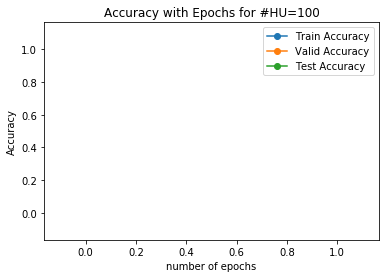

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with Epochs for #HU=100")
#x = np.arange(0,len(costs))
ax.plot(plt_epoch, plt_train_acc, marker='o', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, marker='o', label='Valid Accuracy')
ax.plot(plt_epoch, plt_test_acc, marker='o', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy")

plt.legend()
#plt.savefig("plots/val_loss/accuracy_HiddenUnit100_valloss15per.png", dpi=1000, bbox_inches='tight')
plt.show()

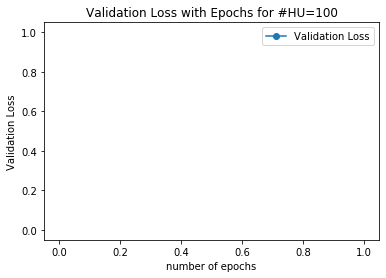

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Validation Loss with Epochs for #HU=100")
x = np.arange(0,len(costs))
ax.plot(x, costs, marker='o', label='Validation Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Validation Loss")

plt.legend()
#plt.savefig("plots/val_loss/partb_val_loss15per_100units.png", dpi=1000, bbox_inches='tight')
plt.show()

In [50]:
len(costs)

17649

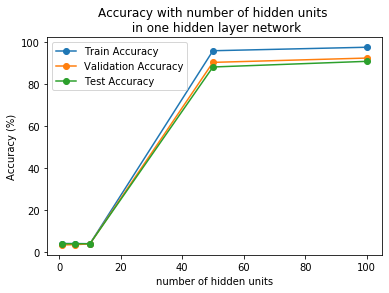

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

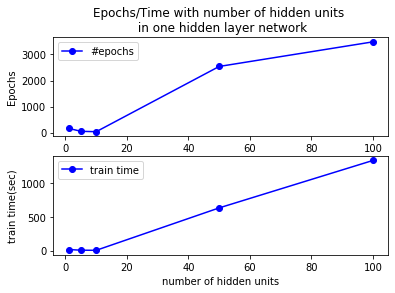

In [116]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("number of hidden units")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("epochs_time_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of epochs for \n 1 hidden layer of 100 units")
ax.plot(plt_epoch, plt_train_acc, c='b', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, c='m',label='Validation Accuracy')
ax.plot(plt_epoch, plt_test_acc, c='g', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_epoch_100_valloss.png", dpi=1000, bbox_inches='tight')
plt.show()